In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

import Data_Preprocessing.Graph_Data as gd
from Data_Preprocessing.Graph_Data import Molecule_data
from models.AttentiveFPModel import AttentiveFP
import seaborn as sns

from models.gat import GATNet
import torch.nn as nn
from models.gcn import GCNNet
from models.gat_gcn import GAT_GCN
from models.ginconv import GINConvNet

In [2]:
df = pd.read_csv('Data_Preprocessing/omdb_smile_data_set.csv')

In [3]:
smiles = df['SMILE']
codIds = df['CODID']
band_gap = df['bgs']

In [4]:
print(band_gap.mean())
print(band_gap.min())
print(band_gap.max())

3.0630082776213756
0.0
8.54


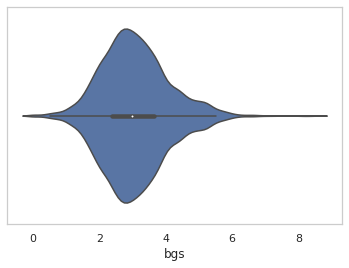

In [5]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

ax = sns.violinplot(x=band_gap)
ax.grid(False)

In [6]:
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(smiles, band_gap, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


In [7]:
# X_train, X_val, y_train, y_val = train_test_split(smiles, band_gap, test_size=0.2)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [9]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [10]:
print(len(y_train))

7957


# Train

In [11]:
smile_graph = {}
band_gap_arr = []
smiles_array = []

# for i,smile in tqdm(enumerate(x_train)):
#     g = gd.smile_to_graph(smile)
#     if g != None:
#         smile_graph[smile] = g
#         band_gap_arr.append(y_train[i])
#         smiles_array.append(smile)

In [12]:
print(len(band_gap_arr))

0


# Validation

In [13]:
smile_graph_val = {}
band_gap_arr_val = []
smiles_array_val = []
for i,smile in enumerate(x_val):
    g = gd.smile_to_graph(smile)
    if g != None:
        smile_graph_val[smile] = g
        band_gap_arr_val.append(y_val[i])
        smiles_array_val.append(smile)

# Test

In [14]:
smile_graph_test = {}
band_gap_arr_test = []
smiles_array_test = []
for i,smile in enumerate(x_test):
    g = gd.smile_to_graph(smile)
    if g != None:
        smile_graph_test[smile] = g
        band_gap_arr_test.append(y_test[i])
        smiles_array_test.append(smile)

# Train Graph

In [15]:
train_data = Molecule_data(root='data', dataset='train_data_set',y=band_gap_arr,smile_graph=smile_graph,smiles=smiles_array)

# Validation Graph

In [16]:
val_data = Molecule_data(root='data', dataset='val_data_set',y=band_gap_arr_val,smile_graph=smile_graph_val,smiles=smiles_array_val)

# Test Graph

In [17]:
test_data = Molecule_data(root='data', dataset='test_data_set',y=band_gap_arr_test,smile_graph=smile_graph_test,smiles=smiles_array_test)

In [18]:
TRAIN_BATCH_SIZE = 17

In [19]:
len(test_data)

2101

In [20]:
len(test_data)

2101

In [21]:
train_loder   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test_loder  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
val_loder  = DataLoader(val_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [22]:
next(iter(train_loder))

Batch(x=[370, 114], edge_index=[2, 772], y=[17], c_size=[17], batch=[370], ptr=[18])

In [23]:
if torch.cuda.is_available():  
    device = "cuda:5"
    print("cuda:5")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:5


In [24]:
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch,loss_fn):
    #print('Training on {} samples...'.format(len(train_loader1.dataset)))
    model.train()
    Loss = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        Loss.append(loss.item())
    nploss = np.asarray(Loss)
    avg_loss = np.average(nploss)
    return avg_loss

In [25]:
def predicting(model, device, loader,loss_fn):
    model.eval()
    total_loss=total_example=0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
            total_loss+=loss
            total_example+=1
    return total_loss/total_example

In [26]:
model = GINConvNet().to(device)
print(model)

GINConvNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (D1_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=114, out_features=198, bias=True)
    (1): ReLU()
    (2): Linear(in_features=198, out_features=198, bias=True)
  ))
  (D1_bn1): BatchNorm1d(198, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=198, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (D1_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (D1_bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias

In [27]:
#LR = 0.005
LR = 8.28967316828403e-05
eps_rate = 1.7687722582665366e-05
weight_decay = 1.3459636454913954e-06
LOG_INTERVAL = 20
NUM_EPOCHS = 3000
results = []

In [28]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [29]:
#loss_fn = nn.MSELoss()
#loss_fn = RMSELoss()
loss_fn = nn.L1Loss()
model = model.cuda(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(),lr=LR,betas=(0.9,0.999),
                                 eps=eps_rate,weight_decay=weight_decay,amsgrad=False)

In [30]:
best_ret = []
best_mse = 0.80
best_ci = 0
patience=0
best_epoch = -1
model_st = "GINConvNet"
model_file_name = 'GINConvNet' + model_st  +  '.model'
result_file_name = 'result_' + model_st +  '.csv'

val_losses = []
train_losses = []

the_last_loss = 100
patience = 26
trigger_times = 0
count_loss_difference = 0

for epoch in range(NUM_EPOCHS):
    train_loss=train(model, device, train_loder, optimizer, epoch+1,loss_fn)
    test_loss = predicting(model, device, val_loder,loss_fn)
#     test_loss = predicting(model, device, test_loder,loss_fn)
#     print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t test mae: %2.5f\t'
#           %(epoch, train_loss, val_loss.item(),test_loss.item()))

    print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t'
          %(epoch, train_loss,test_loss.item()))
    ret = [epoch,train_loss,test_loss.item()]
    
    train_losses.append(train_loss)
    val_losses.append(test_loss.item())
    # Early stopping
    the_current_loss = test_loss.item()
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break
    else:
        
        trigger_times = 0
        the_last_loss = the_current_loss
        torch.save(model.state_dict(), 'GINConvNet.model')


    with open(result_file_name,'w') as f:
        f.write(','.join(map(str,ret)))


Epoch 0: Train mae: 1.96926	 val mae: 1.45811	
Epoch 1: Train mae: 1.54981	 val mae: 1.26964	
Epoch 2: Train mae: 1.43663	 val mae: 1.21345	
Epoch 3: Train mae: 1.39053	 val mae: 1.17085	
Epoch 4: Train mae: 1.32625	 val mae: 1.14364	
Epoch 5: Train mae: 1.27088	 val mae: 1.07611	
Epoch 6: Train mae: 1.24004	 val mae: 1.05131	
Epoch 7: Train mae: 1.20619	 val mae: 1.02377	
Epoch 8: Train mae: 1.19223	 val mae: 1.11842	
trigger times: 1
Epoch 9: Train mae: 1.14288	 val mae: 1.07684	
trigger times: 2
Epoch 10: Train mae: 1.11250	 val mae: 1.00721	
Epoch 11: Train mae: 1.09261	 val mae: 0.92729	
Epoch 12: Train mae: 1.08182	 val mae: 0.92342	
Epoch 13: Train mae: 1.04761	 val mae: 0.90950	
Epoch 14: Train mae: 1.02369	 val mae: 0.91867	
trigger times: 1
Epoch 15: Train mae: 1.01370	 val mae: 0.89648	
Epoch 16: Train mae: 0.97942	 val mae: 0.88195	
Epoch 17: Train mae: 0.96291	 val mae: 0.86597	
Epoch 18: Train mae: 0.93991	 val mae: 0.85228	
Epoch 19: Train mae: 0.92764	 val mae: 0.84662	

Epoch 141: Train mae: 0.42960	 val mae: 0.36111	
Epoch 142: Train mae: 0.43359	 val mae: 0.36124	
trigger times: 1
Epoch 143: Train mae: 0.42484	 val mae: 0.38034	
trigger times: 2
Epoch 144: Train mae: 0.42530	 val mae: 0.36123	
trigger times: 3
Epoch 145: Train mae: 0.42457	 val mae: 0.37040	
trigger times: 4
Epoch 146: Train mae: 0.42938	 val mae: 0.36017	
Epoch 147: Train mae: 0.41911	 val mae: 0.35987	
Epoch 148: Train mae: 0.43434	 val mae: 0.34474	
Epoch 149: Train mae: 0.42618	 val mae: 0.35581	
trigger times: 1
Epoch 150: Train mae: 0.41973	 val mae: 0.35390	
trigger times: 2
Epoch 151: Train mae: 0.42092	 val mae: 0.36969	
trigger times: 3
Epoch 152: Train mae: 0.42830	 val mae: 0.36828	
trigger times: 4
Epoch 153: Train mae: 0.42543	 val mae: 0.34565	
trigger times: 5
Epoch 154: Train mae: 0.41906	 val mae: 0.35141	
trigger times: 6
Epoch 155: Train mae: 0.42045	 val mae: 0.37136	
trigger times: 7
Epoch 156: Train mae: 0.42035	 val mae: 0.36434	
trigger times: 8
Epoch 157: T

Epoch 269: Train mae: 0.37624	 val mae: 0.33723	
trigger times: 14
Epoch 270: Train mae: 0.36854	 val mae: 0.32313	
trigger times: 15
Epoch 271: Train mae: 0.37268	 val mae: 0.32727	
trigger times: 16
Epoch 272: Train mae: 0.37041	 val mae: 0.32810	
trigger times: 17
Epoch 273: Train mae: 0.36128	 val mae: 0.33262	
trigger times: 18
Epoch 274: Train mae: 0.36637	 val mae: 0.33039	
trigger times: 19
Epoch 275: Train mae: 0.37169	 val mae: 0.33088	
trigger times: 20
Epoch 276: Train mae: 0.36892	 val mae: 0.31494	
trigger times: 21
Epoch 277: Train mae: 0.36711	 val mae: 0.32277	
trigger times: 22
Epoch 278: Train mae: 0.36924	 val mae: 0.32101	
trigger times: 23
Epoch 279: Train mae: 0.36610	 val mae: 0.33646	
trigger times: 24
Epoch 280: Train mae: 0.36817	 val mae: 0.31798	
trigger times: 25
Epoch 281: Train mae: 0.36836	 val mae: 0.32063	
trigger times: 26
Early stopping!
Start to test process.


# visualization

In [31]:
len(train_losses)

282

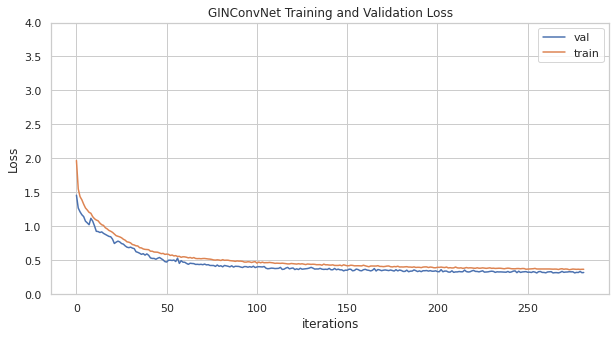

In [32]:
plt.figure(figsize=(10,5))
plt.title("GINConvNet Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 4)
plt.grid(True)
plt.savefig('GINConvNetTrainAndValidation.png', dpi=400,transparent=True)
plt.show()

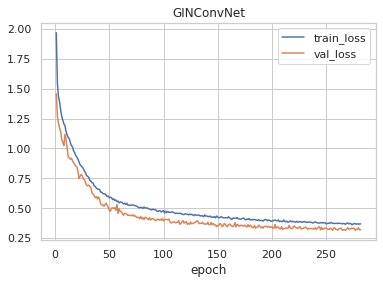

In [33]:
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,len(train_losses) + 1)], train_losses, label="train_loss")
ax.plot([e for e in range(1,len(val_losses) + 1)], val_losses, label="val_loss")
plt.xlabel("epoch")
plt.title('GINConvNet')
plt.grid(True)
plt.savefig('GINConvNetTrain.png', dpi=400,transparent=True)
ax.legend()

In [34]:
y_pred_arr = []
target_array = []
for data in test_loder:
    data = data.to(device)
    y_pred = model(data)
    #y_pred = model(data.x.float(), data.edge_index,data.batch)
    y_pred_arr.append(y_pred)
    target_array.append(data.y.float())

In [35]:
len(test_loder)

124

In [36]:
y_ped=torch.cat(y_pred_arr).view(-1).cpu().detach().numpy()
y_true=torch.cat(target_array).cpu().detach().numpy()

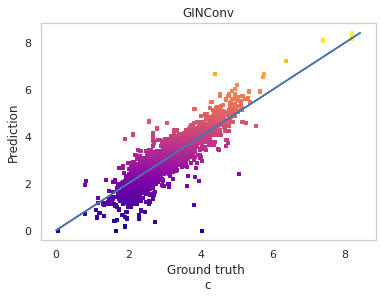

In [37]:
# plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.plot(y_true,y_true)
plt.xlabel('Ground truth \nc')
plt.ylabel('Prediction')
plt.title('GINConv')
plt.grid(False)
plt.savefig('GINConvNet.png', dpi=400,transparent=True,bbox_inches = "tight")
plt.show()

In [38]:
plt.draw()


<Figure size 432x288 with 0 Axes>

In [39]:
plt.savefig("Save Plot as PDF file using savefig.pdf")

<Figure size 432x288 with 0 Axes>

In [40]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [41]:
MSE = mean_squared_error(y_true, y_ped)
print(MSE)

0.2016694


In [42]:
#r2_score(y_true, y_pred)

In [43]:
print(mean_absolute_error(y_true,y_ped))

0.32531825


In [44]:
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.4490761572049224


# Train

In [45]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [46]:
smile = "OC(=O)Cc1c[nH]c2cc(ccc12)CC"

In [47]:
smile_graph = {}
band_gap_arr = []
smiles_array = []

g = gd.smile_to_graph(smile)
if g != None:
    smile_graph[smile] = g
    band_gap_arr.append(0.00)
    smiles_array.append(smile)

In [48]:
one_data = Molecule_data(root='data', dataset='one_data_set',y=band_gap_arr,smile_graph=smile_graph,smiles=smiles_array)

In [49]:
one_loder   = DataLoader(one_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [50]:
next(iter(one_loder))

Batch(x=[15, 114], edge_index=[2, 32], y=[1], c_size=[1], batch=[15], ptr=[2])

In [51]:
for data in one_loder:
    data = data.to(device)
    y_pred = model(data)
    print(y_pred)

tensor([[3.2432]], device='cuda:5', grad_fn=<AddmmBackward>)


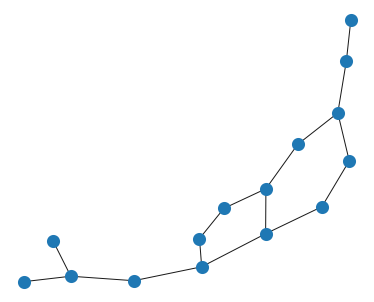

In [52]:
import networkx as nx
from torch_geometric import torch_geometric
for data in one_loder:
    data = data.to(device)
    gdata = torch_geometric.data.Data(x=data.x.float(), edge_index=data.edge_index)
    g = torch_geometric.utils.to_networkx(gdata, to_undirected=True)
    plt.figure(1,figsize=(5,4)) 
    nx.draw(g, cmap=plt.get_cmap('Set1'),node_size=50,linewidths=6)
#     plt.show()
#     nx.draw(g)
    break

#### 